In [1]:
%load_ext autoreload
%autoreload 2

%cd ..
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

/cis/home/dpacker/my_documents/hoffman-coffee


In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src import exploratory
import numpy as np
from sklearn import decomposition, manifold
import numpyro
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from graphviz import Digraph
from jax import random
from numpyro.infer import MCMC, NUTS

p_data_folder = Path("data")
p_plots = Path("plots")
p_data_file = p_data_folder / "hoffman_coffee.csv"
data = pd.read_csv(p_data_file)

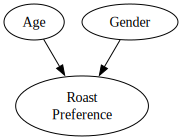

In [100]:
dot = Digraph()

dot.node("A", label="Age")
dot.node("G", label="Gender")
dot.node("R", label="Roast\nPreference")
dot.edges(["AR", "GR"])
dot

In [143]:
cols = ["What is your age?", "Gender", "What roast level of coffee do you prefer?"]
data_subset = data[cols]
data_subset.columns = ["Age", "Gender", "Roast"]
# For now, we won't deal with missingness:
data_subset = data_subset.dropna()

# Subsetting the data for simplicity:
genders = ["Female", "Male", "Non-binary"]
roasts = ["Light", "Medium", "Dark", "Blonde", "Nordic"]
ages = [
    "<18 years old",
    "18-24 years old",
    "25-34 years old",
    "35-44 years old",
    "45-54 years old",
    "55-64 years old",
    ">65 years old",
]

data_subset = data_subset[
    data_subset["Gender"].apply(lambda g: g in genders)
    & data_subset["Roast"].apply(lambda r: r in roasts)
]

data_onehot = pd.get_dummies(data_subset, drop_first=True)

In [102]:
def model_A1(gender_is_male=None, roast_is_light=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.1))
    gender_effect = 0.0
    # sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    if gender_is_male is not None:
        bMale = numpyro.sample("bMale", dist.Normal(0.0, 0.5))
        gender_effect = bMale * gender_is_male

    mu = a + gender_effect

    numpyro.sample("obs", dist.Bernoulli(logits=mu), obs=roast_is_light)

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1148.07it/s, 15 steps of size 5.23e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.44      0.05     -0.44     -0.53     -0.34    319.48      1.00
     bMale      0.47      0.07      0.47      0.35      0.57    318.12      1.00

Number of divergences: 0


<Axes: xlabel='a', ylabel='bMale'>

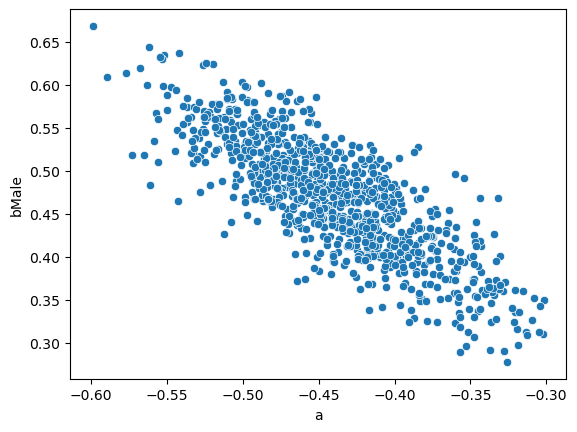

In [103]:
nuts_kernel = NUTS(model_A1)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1_000)
rng_key = random.PRNGKey(seed=1)

mcmc.run(rng_key, np.array(data_subset["Gender"] == "Male"), np.array(data_subset["Roast"] == "Light"))
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
sns.scatterplot(samples, x="a", y="bMale")

In [125]:
def model_A2(gender_one_hot=None, roast_is_light=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    gender_effect = 0.0

    if gender_one_hot is not None:
        b_gender = numpyro.sample("b_gender", dist.Normal(np.zeros(shape=[2]), 0.5))
        gender_effect = gender_one_hot @ b_gender

    mu = a + gender_effect

    numpyro.sample("obs", dist.Bernoulli(logits=mu), obs=roast_is_light)

In [126]:
gender_onehot = np.array(pd.get_dummies(data_subset["Gender"], drop_first=True))

In [127]:
nuts_kernel = NUTS(model_A2)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1_000)
rng_key = random.PRNGKey(seed=1)

mcmc.run(rng_key, gender_onehot, np.array(data_subset["Roast"] == "Light"))
mcmc.print_summary()
# samples = mcmc.get_samples(group_by_chain=False)
# sns.scatterplot(samples, x="a", y="bMale")

  0%|          | 0/2000 [00:00<?, ?it/s]

sample: 100%|██████████| 2000/2000 [00:02<00:00, 996.52it/s, 7 steps of size 4.36e-01. acc. prob=0.92] 


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     -0.65      0.07     -0.65     -0.77     -0.55    407.96      1.00
b_gender[0]      0.68      0.08      0.68      0.56      0.81    413.16      1.00
b_gender[1]      0.74      0.19      0.74      0.46      1.06    593.17      1.00

Number of divergences: 0


In [149]:
def model_A3(age_onehot=None, gender_one_hot=None, roast_is_light=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    gender_effect = 0.0
    age_effect = 0.0

    if gender_one_hot is not None:
        b_gender = numpyro.sample("b_gender", dist.Normal(np.zeros(shape=[2]), 0.5))
        gender_effect = gender_one_hot @ b_gender

    if age_effect is not None:
        b_age = numpyro.sample("b_age", dist.Normal(np.zeros(shape=[6]), 0.5))
        age_effect = age_onehot @ b_age
    

    mu = a + gender_effect + age_effect

    numpyro.sample("obs", dist.Bernoulli(logits=mu), obs=roast_is_light)

age_onehot = np.array(pd.get_dummies(data_subset["Age"], drop_first=False)[ages[1:]])
gender_onehot = np.array(pd.get_dummies(data_subset["Gender"], drop_first=False)[genders[1:]])

In [151]:
nuts_kernel = NUTS(model_A3)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1_000)
rng_key = random.PRNGKey(seed=1)

mcmc.run(rng_key, age_onehot, gender_onehot, np.array(data_subset["Roast"] == "Light"))
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
# sns.scatterplot(samples, x="a", y="bMale")

sample: 100%|██████████| 2000/2000 [00:03<00:00, 551.63it/s, 7 steps of size 2.24e-01. acc. prob=0.91] 


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a     -0.48      0.14     -0.48     -0.72     -0.27    307.56      1.00
   b_age[0]     -0.35      0.18     -0.35     -0.63     -0.05    349.66      1.00
   b_age[1]      0.01      0.15     -0.00     -0.24      0.24    275.51      1.00
   b_age[2]     -0.15      0.16     -0.16     -0.40      0.11    308.79      1.00
   b_age[3]     -0.50      0.19     -0.50     -0.79     -0.20    378.31      1.00
   b_age[4]     -1.12      0.22     -1.12     -1.52     -0.79    499.87      1.00
   b_age[5]     -1.13      0.27     -1.14     -1.55     -0.64    661.08      1.00
b_gender[0]      0.68      0.08      0.68      0.54      0.80    826.57      1.00
b_gender[1]      0.67      0.19      0.67      0.36      0.96    849.53      1.00

Number of divergences: 0


<Axes: ylabel='Density'>

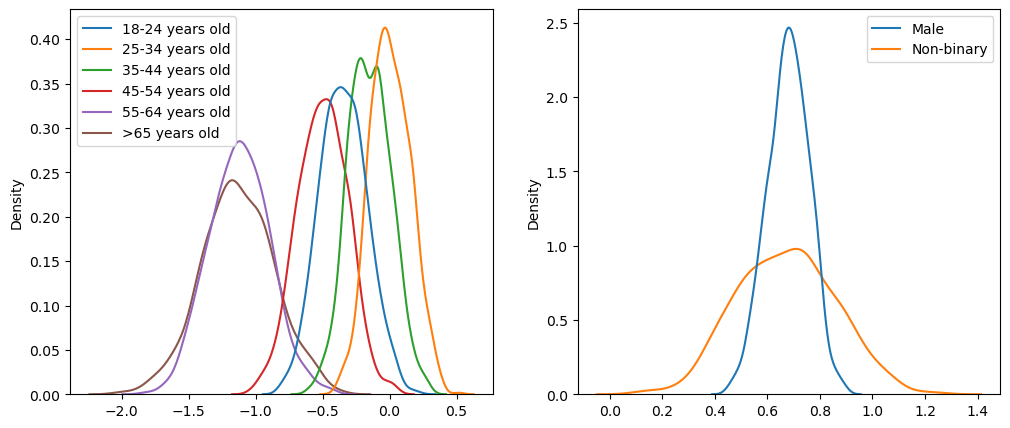

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(pd.DataFrame(samples["b_age"], columns=ages[1:]), ax=axs[0])
sns.kdeplot(pd.DataFrame(samples["b_gender"], columns=genders[1:]), ax=axs[1])

In [184]:
def model_A4(gender_is_male=None, roast_type=None):
    a = numpyro.sample("a", dist.Normal(np.zeros(shape=[5]), 0.1))
    gender_effect = 0.0
    # sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    if gender_is_male is not None:
        bMale = numpyro.sample("bMale", dist.Normal(np.zeros(shape=[5]), 0.5))
        gender_effect = bMale * gender_is_male[:, None]

    mu = a + gender_effect

    numpyro.sample("obs", dist.CategoricalLogits(mu), obs=roast_type)

roast_numeric = np.array(data_subset["Roast"].apply(dict(zip(roasts, range(len(roasts)))).get))
gender_is_male = np.array(data_subset["Gender"] == "Male")

In [185]:
nuts_kernel = NUTS(model_A4)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1_000)
rng_key = random.PRNGKey(seed=1)

mcmc.run(rng_key, gender_is_male, roast_numeric)
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)

sample: 100%|██████████| 2000/2000 [00:08<00:00, 237.89it/s, 31 steps of size 1.41e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]      0.55      0.07      0.55      0.44      0.66    857.92      1.00
      a[1]      0.79      0.07      0.79      0.67      0.90    790.11      1.00
      a[2]     -0.01      0.07     -0.02     -0.13      0.12    855.66      1.00
      a[3]     -0.60      0.08     -0.60     -0.73     -0.47    969.57      1.00
      a[4]     -0.73      0.08     -0.73     -0.86     -0.61    885.74      1.00
  bMale[0]      1.18      0.24      1.17      0.78      1.56    245.89      1.00
  bMale[1]      0.64      0.24      0.63      0.29      1.05    245.18      1.00
  bMale[2]     -0.11      0.25     -0.11     -0.49      0.30    269.72      1.00
  bMale[3]     -1.13      0.28     -1.12     -1.51     -0.61    306.70      1.00
  bMale[4]     -0.55      0.26     -0.54     -0.98     -0.14    279.47      1.00

Number of divergences: 0


In [190]:
def model_A5(gender_onehot=None, roast_type=None):
    a = numpyro.sample("a", dist.Normal(np.zeros(shape=[5]), 0.1))
    gender_effect = 0.0
    # sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    if gender_onehot is not None:
        b_gender = numpyro.sample("b_gender", dist.Normal(np.zeros(shape=[2, 5]), 0.5))
        gender_effect = jnp.sum(b_gender[None, :, :] * gender_onehot[:, :, None], axis = 1)

    mu = a + gender_effect

    numpyro.sample("obs", dist.CategoricalLogits(mu), obs=roast_type)

roast_numeric = np.array(data_subset["Roast"].apply(dict(zip(roasts, range(len(roasts)))).get))
gender_onehot = np.array(pd.get_dummies(data_subset["Gender"], drop_first=False)[genders[1:]])

In [192]:
nuts_kernel = NUTS(model_A5)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1_000)
rng_key = random.PRNGKey(seed=1)

mcmc.run(rng_key, gender_onehot, roast_numeric)
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)

sample: 100%|██████████| 2000/2000 [00:11<00:00, 174.51it/s, 31 steps of size 1.36e-01. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         a[0]      0.47      0.07      0.47      0.35      0.57   1041.44      1.00
         a[1]      0.79      0.06      0.79      0.69      0.90    731.68      1.00
         a[2]      0.01      0.07      0.01     -0.10      0.13   1060.47      1.00
         a[3]     -0.57      0.08     -0.57     -0.69     -0.44   1260.15      1.00
         a[4]     -0.71      0.08     -0.71     -0.85     -0.60   1178.00      1.00
b_gender[0,0]      1.26      0.25      1.26      0.89      1.69    293.19      1.00
b_gender[0,1]      0.63      0.24      0.64      0.24      1.02    291.34      1.01
b_gender[0,2]     -0.14      0.25     -0.12     -0.57      0.23    317.42      1.01
b_gender[0,3]     -1.15      0.27     -1.14     -1.57     -0.71    338.76      1.01
b_gender[0,4]     -0.56      0.26     -0.55     -0.95     -0.11    362.06      1.01
b_gender[1,0]      1.06      0.29      1.05      0.57      1.50    687.42  

In [194]:
roasts

['Light', 'Medium', 'Dark', 'Blonde', 'Nordic']